# Enunciado

![alt text](Imagens/Enunciado/Enunciado1.1.png)

![alt text](Imagens/Enunciado/Enunciado1.2.png)

![alt text](Imagens/Enunciado/Enunciado1.3.png)

![alt text](Imagens/Enunciado/Enunciado1.4.png)

# Codigos

## Gerar Histogramas


Calculando N = 100...
  Fração 0%: 0.00 segundos
  Fração 1%: 0.00 segundos
  Fração 2%: 0.00 segundos
  Fração 3%: 0.00 segundos
  Fração 4%: 0.00 segundos
  Fração 5%: 0.00 segundos


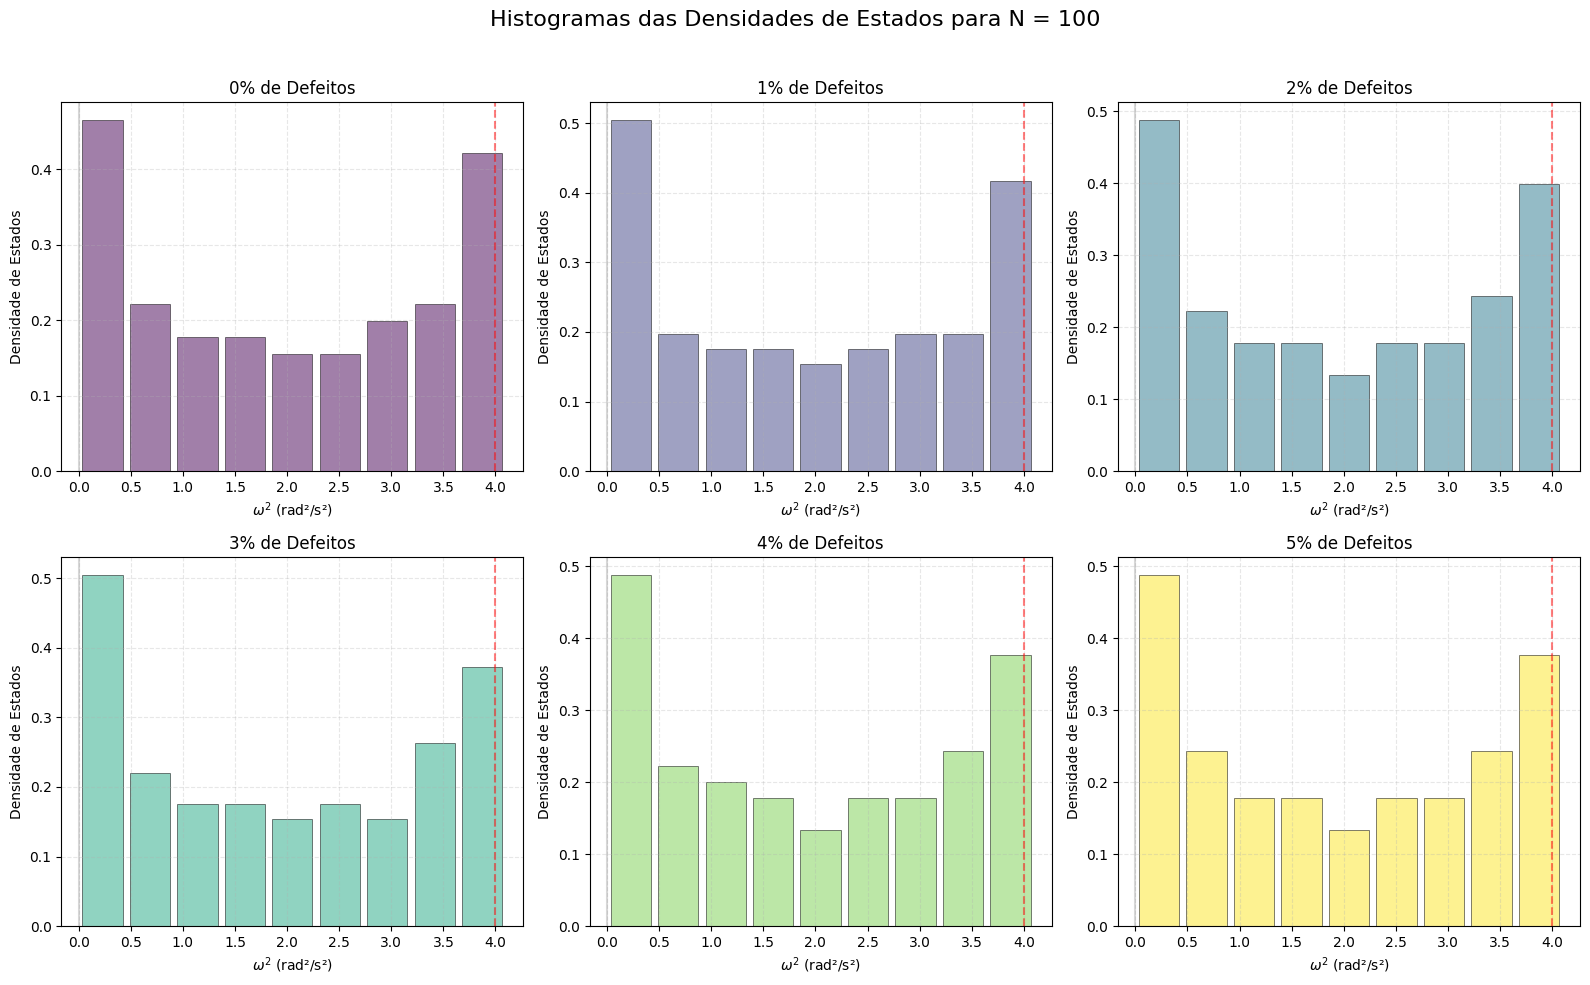


Calculando N = 1000...
  Fração 0%: 0.01 segundos
  Fração 1%: 0.01 segundos
  Fração 2%: 0.01 segundos
  Fração 3%: 0.01 segundos
  Fração 4%: 0.02 segundos
  Fração 5%: 0.01 segundos


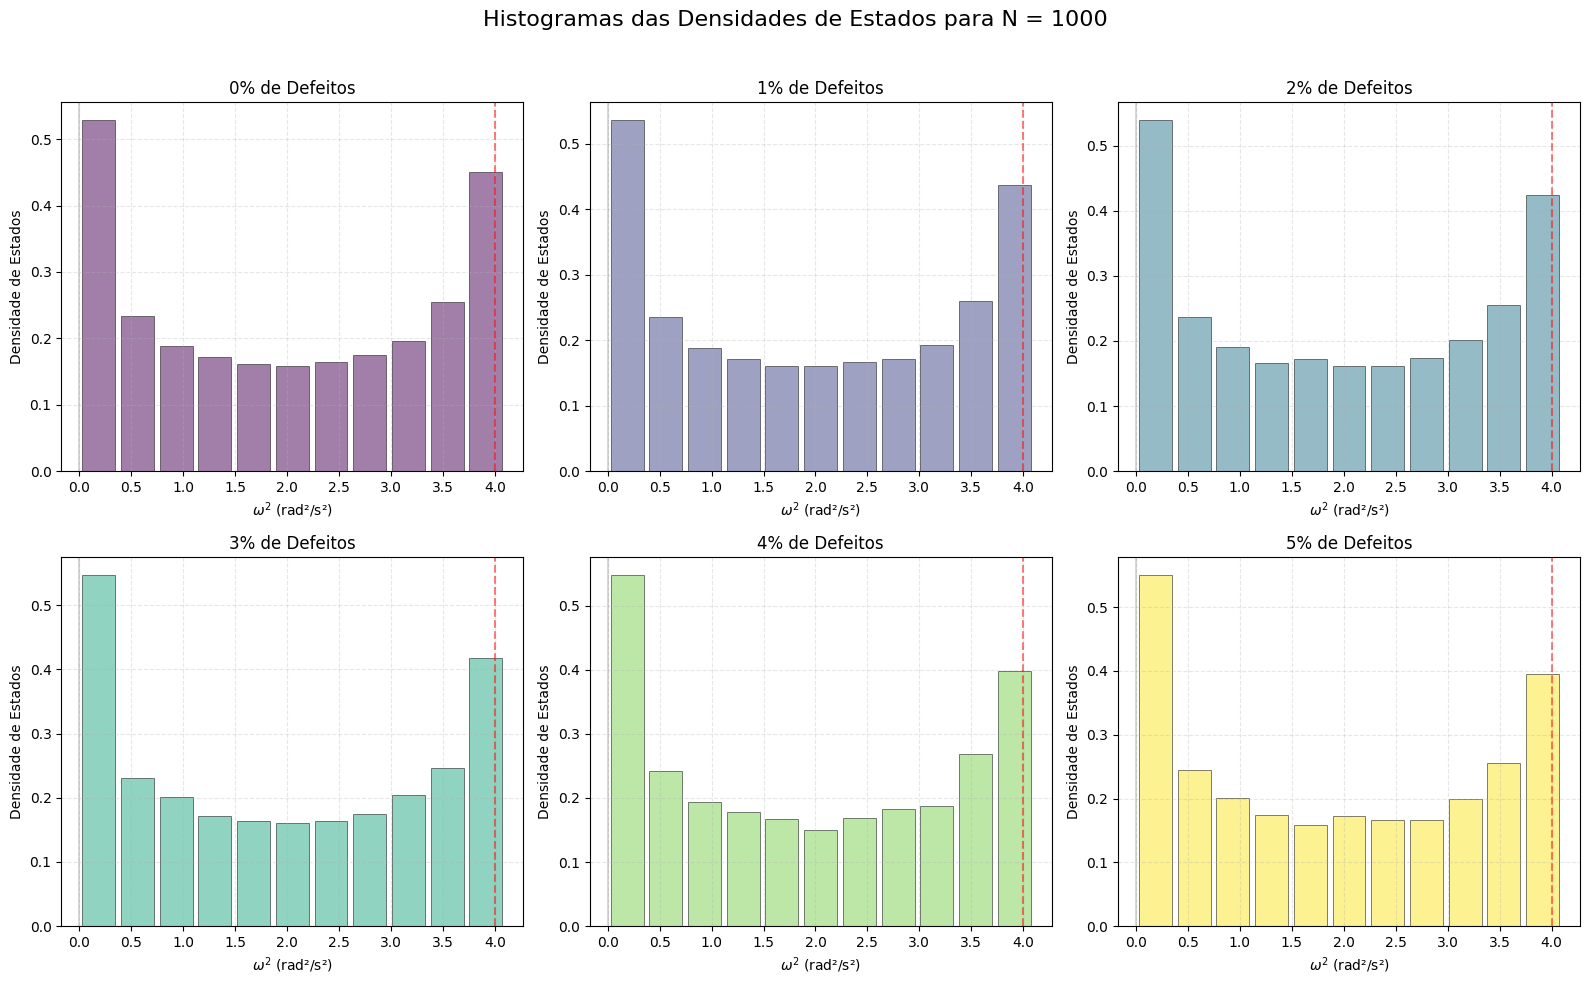


Calculando N = 10000...
  Fração 0%: 1.15 segundos
  Fração 1%: 1.15 segundos
  Fração 2%: 1.19 segundos
  Fração 3%: 1.19 segundos
  Fração 4%: 1.20 segundos
  Fração 5%: 1.27 segundos


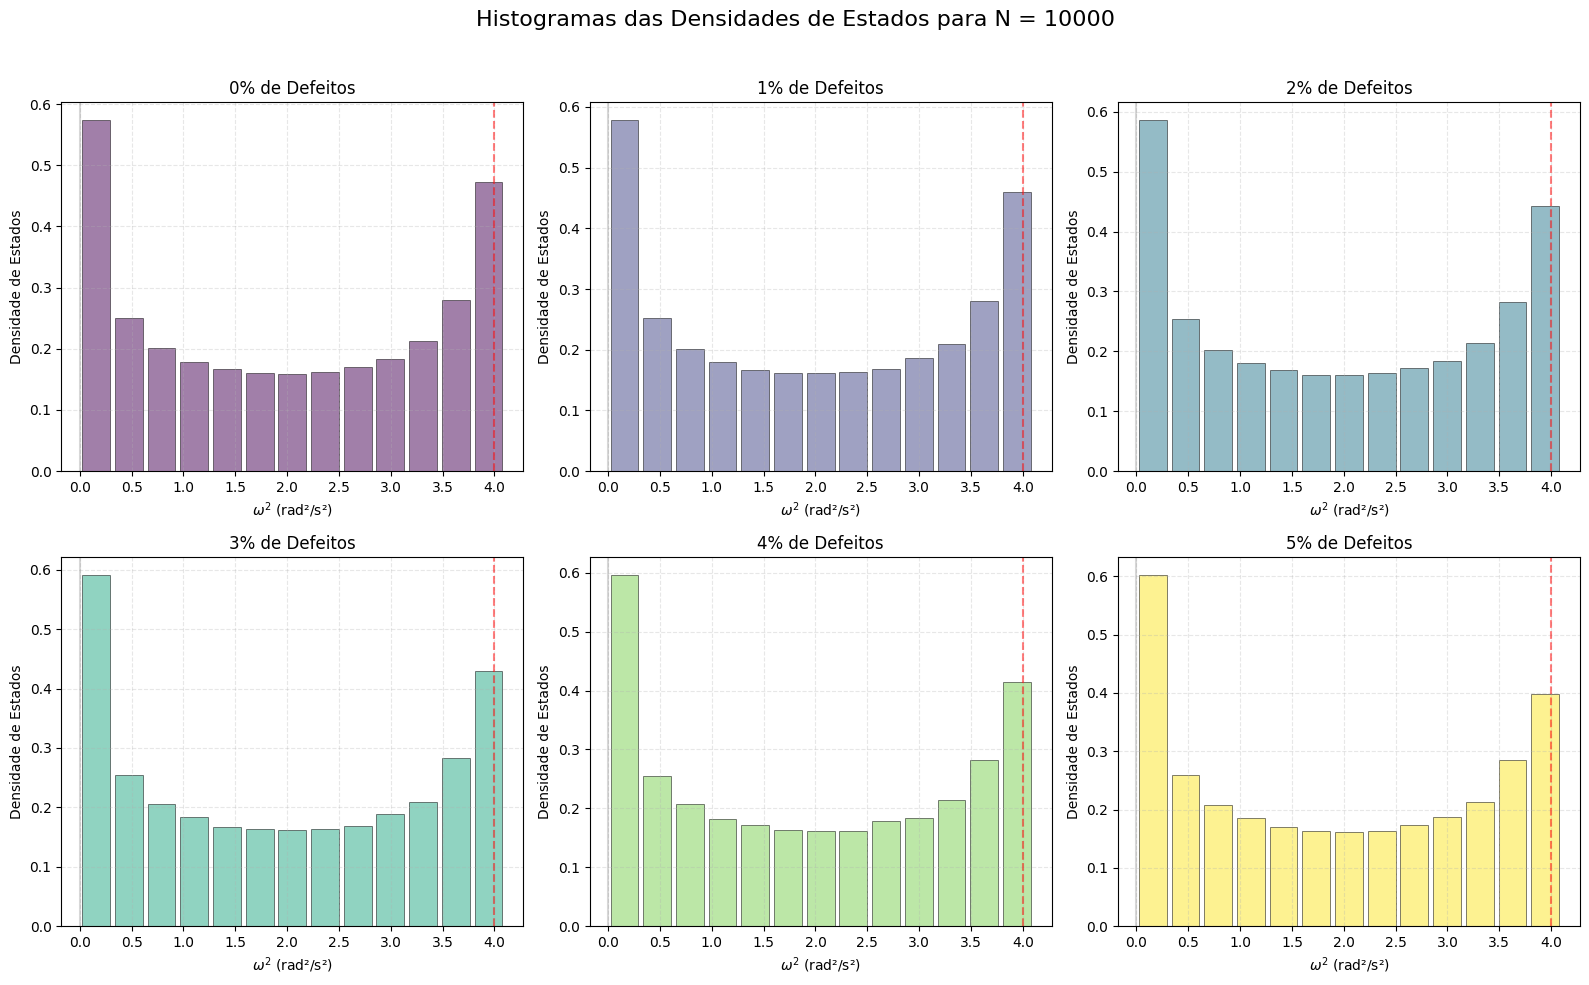

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.linalg import eigh_tridiagonal
import matplotlib.cm as cm

# Parâmetros
m = 1.0          # Massa base (kg)
k = 1.0          # Constante elástica (kg/s²)
N_values = [100, 1000, 10000]  # Tamanhos das cadeias
defect_fractions = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05]  # Frações de defeitos
num_bins = [9,11,13]    # Número de bins para o histograma
omega2_max = 4.1 # Valor máximo de ω² para histogramas
np.random.seed(42) # Semente para reprodutibilidade

# Paleta de cores
colors = cm.viridis(np.linspace(0, 1, len(defect_fractions)))

# Função para gerar vetor de massas com defeitos
def generate_masses(N, defect_fraction):
    masses = np.full(N, m)  # Todos átomos com massa m
    if defect_fraction > 0:
        num_defects = int(N * defect_fraction)
        defect_indices = np.random.choice(N, num_defects, replace=False)
        masses[defect_indices] = 3 * m  # Defeitos com massa 3m
    return masses

# Função para calcular as frequências ao quadrado (autovalores)
def compute_frequencies(masses, k):
    N = len(masses)
    # Diagonal principal
    main_diag = np.zeros(N)
    main_diag[0] = k / masses[0]        # Primeiro átomo
    main_diag[-1] = k / masses[-1]       # Último átomo
    if N > 2:
        main_diag[1:-1] = 2 * k / masses[1:-1]  # Átomos internos
    
    # Diagonal secundária
    off_diag = np.zeros(N-1)
    for i in range(N-1):
        off_diag[i] = -k / np.sqrt(masses[i] * masses[i+1])
    
    # Calcular autovalores (ω²)
    eigenvalues = eigh_tridiagonal(main_diag, off_diag, eigvals_only=True)
    return eigenvalues

# Simulação para cada tamanho de cadeia

aux_bins = 0
for N in N_values:
    # Criar figura com subplots para cada fração
    fig, axes = plt.subplots(2, 3, figsize=(16, 10)) 
    fig.suptitle(f'Histogramas das Densidades de Estados para N = {N}', fontsize=16, y=0.98)
    
    print(f"\nCalculando N = {N}...")
    eigenvalues_data = []
    
    # Primeiro: calcular todos os dados
    for frac_idx, frac in enumerate(defect_fractions):
        start_time = time.time()
        masses = generate_masses(N, frac)
        eigenvalues = compute_frequencies(masses, k)
        eigenvalues_data.append(eigenvalues)
        print(f"  Fração {frac*100:.0f}%: {time.time()-start_time:.2f} segundos")
    
    # Determinar bins comuns para todos
    all_eigenvalues = np.concatenate(eigenvalues_data)
    hist_all, bin_edges = np.histogram(all_eigenvalues, bins=num_bins[aux_bins], range=(0, omega2_max), density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[:-1] + bin_width / 2
    
    aux_bins += 1  #Auxiliar para a lista de bins
    # Segundo: plotar cada fração em seu próprio subplot
    for frac_idx, (frac, eigenvalues) in enumerate(zip(defect_fractions, eigenvalues_data)):
        ax = axes[frac_idx//3, frac_idx%3]  # Selecionar subplot (2 linhas, 3 colunas)
        
        # Calcular histograma
        hist, _ = np.histogram(eigenvalues, bins=bin_edges, density=True)
        
        # Plotar barras
        ax.bar(
            bin_centers, 
            hist, 
            width=bin_width * 0.85,  # 85% da largura para espaço entre barras
            alpha=0.5, 
            color=colors[frac_idx],
            edgecolor='black',
            linewidth=0.7
        )
        
        # Adicionar título e informação
        ax.set_title(f'{frac*100:.0f}% de Defeitos', fontsize=12)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Adicionar linhas de referência
        ax.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
        ax.axvline(x=4, color='red', linestyle='--', alpha=0.5)
        
        # Adicionar texto informativo
        """
        ax.text(0.05, 0.95, f'Média: {np.mean(eigenvalues):.2f}', 
                transform=ax.transAxes, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.3))
        """
    # Configurar eixos e rótulos
    for ax in axes.flatten():
        ax.set_xlabel('$\omega^2$ (rad²/s²)', fontsize=10)
        ax.set_ylabel('Densidade de Estados', fontsize=10)
    
    # Ajustar layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Espaço para o título superior
    plt.savefig(f'dos_N{N}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Gerar a Evolução temporal dos modos

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.linalg import eigh_tridiagonal

# Parâmetros
N = 100  # Tamanho da cadeia
defect_fraction = 0.0 # Fração de defeitos
m = 1.0
k = 1.0
mode_index = 50 # indice do modo a ser animado

# Configurar semente para reprodutibilidade
np.random.seed(00)

# Gerar massas e defeitos
masses = np.full(N, m)
defect_indices = np.random.choice(N, int(N * defect_fraction), replace=False)
masses[defect_indices] = 3 * m
  
# Calcular matriz dinâmica
main_diag = np.zeros(N)
main_diag[0] = k / masses[0]
main_diag[-1] = k / masses[-1]
main_diag[1:-1] = 2 * k / masses[1:-1]

off_diag = np.zeros(N-1)
for i in range(N-1):
    off_diag[i] = -k / np.sqrt(masses[i] * masses[i+1])

# Obter autovalores e autovetores
eigenvals, eigenvecs = eigh_tridiagonal(main_diag, off_diag)
frequencies = np.sqrt(eigenvals)

# Selecionar o segundo modo 
omega = np.sqrt(eigenvals[mode_index])
mode_vector = eigenvecs[:, mode_index]



# Configurar animação
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0, N)
ax.set_ylim(-1.5, 1.5)
ax.set_title(f'Evolução Temporal de Modos Normais - Modo {mode_index+1} ($\omega$ = {omega:.4f} rad/s) - N={N}, {defect_fraction*100}% Defeitos')
ax.set_xlabel('Posição do Átomo')
ax.set_ylabel('Deslocamento')

# Elementos do gráfico
line, = ax.plot([], [], 'o-', markersize=4)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# Destacar defeitos
for idx in defect_indices:
    ax.axvline(x=idx, color='r', alpha=0.3, linewidth=1)

# Função de inicialização
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

# Função de animação
def animate(t):
    # Calcular deslocamentos: u(x,t) = ψ(x) * cos(ωt)
    displacements = mode_vector * np.cos(omega * t)
    
    # Atualizar gráfico
    line.set_data(np.arange(N), displacements)
    time_text.set_text(f'Tempo: {t:.2f} s')
    return line, time_text


# Criar animação
ani = FuncAnimation(
    fig, animate, frames=np.linspace(0, 4*np.pi/omega, 200),
    init_func=init, blit=True, interval=50
)
print("modo: ", mode_index, "omega: ", omega)
plt.tight_layout()
ani.save(f'Modo_{mode_index}_sem_defeitos.gif', writer='pillow', fps=20)
plt.close()

C:\Users\vinic\AppData\Local\Temp\ipykernel_12012\2640763048.py:33: RuntimeWarning: invalid value encountered in sqrt
  frequencies = np.sqrt(eigenvals)


modo:  50 omega:  1.4142135623730951


## Obter as 5 maiores e menores frequências

In [ ]:
#Transformam nan em 0
frequencies = np.nan_to_num(frequencies)

print("As 5 menores e maiores frequências da cadeia atômica são:")
print("\n- 5 menores frequências (ω):")
for freq in frequencies[:5]:
    print(f"  {freq:.2e}")
print("\n- 5 maiores frequências (ω):")
for freq in frequencies[-5:]:
    print(f"  {freq:.4f}")

# A menor frequencia foi transformada manualmente em 0, pois é um valor muito próximo de zero

As 5 menores e maiores frequências da cadeia atômica são:

- 5 menores frequências (ω):
  0.00e+00
  3.00e-04
  5.99e-04
  9.00e-04
  1.20e-03

- 5 maiores frequências (ω):
  1.9997
  1.9998
  1.9998
  1.9998
  1.9998


# **Resposta Moodle**

## **1. Introdução**

O modelo massa-mola apresentado consiste em N átomos de massa base **m** conectados por molas idênticas de constante elástica **k**, sob condições de contorno livres. Defeitos de massa são introduzidos substituindo aleatoriamente uma fração dos átomos por átomos com massa **3m**. Dessa forma, o objetivo principal é analisar como o aumento da concentração de defeitos de massa afeta a densidade de estados vibracionais (DOS), além de alterações no espectro de frequências.

## **2. Metodologia**

Primeiramente, foram calculadas as massas do sistema para uma cadeia com N átomos, com defeitos gerados de forma aleatória entre 0% e 5% de defeitos.
Posteriormente, foi calculada a matriz dinâmica do sistema da seguinte forma: 
Começando com a diagonal principal e considerando que a cadeia é livre nas extremidades, a fórmula para calcular esses valores é alterada para o primeiro e enésimo átomo, seguindo a seguinte lei de formação:

![alt text](Imagens/Enunciado/resp_moodle_1.png)

Em seguida, as diagonais secundárias da seguinte forma: 

![alt text](Imagens/Enunciado/resp_moodle_2.png)

É importante notar que a matriz é **tridiagonal** (somente as diagonais principal, superior e inferior não são nulas), é **simétrica** (Todo Dij = Dji) e **Hermitiana** (Possui todos os elementos reais e D = D.T)
Isso é importante computacionalmente, pois os autovalores e autovetores dessa matriz podem ser calculados com o uso da função "eigh_triadiagonal" ao invés da função "eig" do pacote SciPy do Python. Fazendo com o que a matriz seja gerada de forma muito mais rápida e consumindo menos memória.
Já as frequências, são obtidas a partir da raiz dos autovalores da matriz dinâmica, enquanto os modos são obtidos a partir dos autovetores

## 3. Resultados e Discussão

**Densidade dos Estados**

![alt text](Imagens/Histogramas/dos_N100.png)

![alt text](Imagens/Histogramas/dos_N1000.png)

![alt text](Imagens/Histogramas/dos_N10000.png)

É possível observar como os defeitos de massa influenciam a densidade de estados vibracionais em um sistema unidimensional. A presença de átomos mais pesados (defeitos) cria picos em certas regiões da cadeia, correspondendo a modos localizados, enquanto reduz a disponibilidade de estados em altas frequências (ω² > 3,0), diminuindo a frequência máxima com o aumento da quantidade de erros, demonstrando que os defeitos alteram significativamente a distribuição de estados vibracionais na rede.
A quantidade de "bins" escolhidos para o histograma foram com base na Regra de Sturges, aproximado para valores ímpares. A regra é:
k=1+3,322⋅log10​(N), onde
k é o número de bins
n o número de pontos análisados. 

**Frequências para N = 100 com 5% de erros**

| Maiores Frequências        | Menores Frequências                   |
|------------------------------------|------------------------------------------------|
| 1.9867 | 0        | 
| 1.9885 | 2.98e-02 |           
| 1.9885 | 6.01e-02 | 
| 1.9958 | 8.98e-02 | 
| 1.9971 | 1.18e-01 |


**Comparação Modos Vibracionais**

<table>
  <tr>
    <td><img src="Imagens/Gifs/Modo_3_sem_defeitos.gif" alt="Descrição 1" width="500px"></td>
    <td><img src="Imagens/Gifs/Modo_3_defeitos.gif" alt="Descrição 2" width="500px"></td>
  </tr>
</table>
<table>
  <tr>
    <td><img src="Imagens/Gifs/Modo_51_sem_defeitos.gif" alt="Descrição 1" width="500px"></td>
    <td><img src="Imagens/Gifs/Modo_51_defeitos.gif" alt="Descrição 2" width="500px"></td>
  </tr>
</table>
<table>
  <tr>
    <td><img src="Imagens/Gifs/Modo_100_sem_defeitos.gif" alt="Descrição 1" width="500px"></td>
    <td><img src="Imagens/Gifs/Modo_100_defeitos.gif" alt="Descrição 2" width="500px"></td>
  </tr>
</table>

Massas maiores atuam como "armadilhas" para energia vibracional, localizando os modos normais próximos aos defeitos. Isso se manifesta em autovetores com amplitude decaindo exponencialmente a partir do defeito.
Ao verificar as frequências de vibração da cadeia atômica com defeitos, não aparece um "buraco" completo no espectro (ou seja, não tem uma faixa de frequências totalmente proibidas). Também foi possível verificar um alargamento da banda vibracional. A faixa de frequências onde ocorrem vibrações fica mais "espalhada" do que numa cadeia perfeita (sem defeitos). Isso acontece porque os defeitos "empurram" algumas frequências para valores diferentes, aumentando a dispersão.

Com relação as possíveis aplicações das alterações de massa em cadeias de átomos. É possível ocorrer em materiais termoelétricos, onde defeitos podem reduzir a condutividade térmica via confinamento de vibrações, são relevantes também para sensores de massa, pois modos localizados são sensíveis à adsorção molecular (processo em que moléculas se ligam à superfície de um material), e para filtros acústicos, onde defeitos controlam a propagação de ondas mecânicas.

## 4. Conclusão

Este exercício demonstrou que defeitos de massa em cadeias unidimensionais provocam alterações significativas nas propriedades vibracionais do sistema. Sendo possível observar modos localizados predominantemente em baixas frequências (ω² < 0,5), caracterizados por amplitudes máximas nos átomos defeituosos e um decaimento exponencial à medida que se afastam desses centros.
Além disso, uma consequência direta da introdução de defeitos foi a redução linear da frequência máxima do sistema em função da fração de átomos alterados, ou seja, quanto mais eram adicionados átomos defeituosos, registraram-se um decréscimo maior da frequência máxima em comparação com a cadeia perfeita.
Esses resultados sugerem que a presença de defeitos de massa modifica substancialmente a dinâmica vibracional da cadeia, promovendo tanto a localização de modos quanto alterações sistemáticas nas propriedades espectrais. A ausência de lacunas completas, combinada com a redistribuição observada na densidade de estados, aponta para um cenário onde os defeitos introduzem desordem sem eliminar completamente a possibilidade de propagação vibracional nas faixas de frequências.